In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import specphotoz
from specphotoz import RedshiftEstimatorkNN, RedshiftEstimatorANN

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

In [3]:
redshift_estimator_dict = {'kNN': RedshiftEstimatorkNN,
                           'ANN': RedshiftEstimatorANN
                           }

## Read in data

In [4]:
# Load data
print("Loading data")
fn_gaia = '../data/gaia_clean.fits'
tab_gaia = utils.load_table(fn_gaia)
# TEST ONLY W SMALL AMOUNT
#tab_gaia = tab_gaia[np.random.randint(0, len(tab_gaia), size=10000)]
N_gaia = len(tab_gaia)
print(f"N of clean gaia catalog: {N_gaia}")

Loading data
N of clean gaia catalog: 1451214


In [5]:
G_max = 20.5

In [6]:
# Make Gmax cut, because will be more robust that way if we cut first
i_makeGcut = tab_gaia['phot_g_mean_mag'] < G_max
tab_gaia = tab_gaia[i_makeGcut]
print(f"N after G_max cut of G<{G_max}:", len(tab_gaia))

N after G_max cut of G<20.5: 1104830


In [7]:
feature_keys = ['redshift_qsoc', 'ebv', 'g_rp', 'bp_g', 'bp_rp', 'g_w1', 'w1_w2', 'phot_g_mean_mag']
X_gaia = specphotoz.construct_X(tab_gaia, feature_keys)

# ANN

In [8]:
redshift_estimator_name = 'ANN'
G_max = 20.5
learning_rate = 0.005
#save_tag = f'_lr{learning_rate}_valid'
save_tag = f'_regression_lr{learning_rate}'
#save_tag = '_lr0.005'

In [9]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [10]:
fn_model = f'../data/redshift_models/model_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
redshift_estimator_class = redshift_estimator_dict[redshift_estimator_name]                        
redshift_estimator = redshift_estimator_class(train_mode=False, test_mode=False, feature_keys=None)
redshift_estimator.load_model(fn_model)

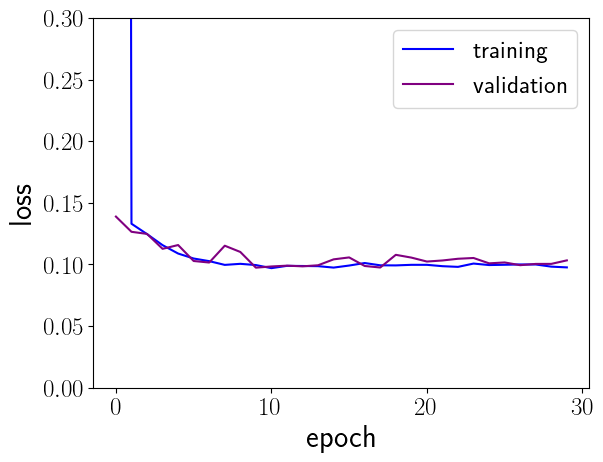

In [11]:
plt.plot(redshift_estimator.loss_train, color='blue', label='training')
plt.plot(redshift_estimator.loss_valid, color='purple', label='validation')
plt.ylim(0, 0.3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [12]:
i_test = tab_spz['chunk_spz']=='test'

In [13]:
len(tab_spz), X_gaia.shape

(1104830, (1104830, 8))

In [14]:
np.where(tab_spz['chunk_spz']=='test')

(array([   3824,    3830,    3857, ..., 1096379, 1096390, 1096572]),)

In [15]:
i_sort = np.argsort(tab_spz['source_id'][i_test])

In [16]:
Y_test = tab_spz['sdss_Z'][i_test][i_sort]
Y_spz_test_ANN = tab_spz['redshift_spz'][i_test][i_sort]
Y_spzqsoc_test_ANN = tab_spz['redshift_spzqsoc'][i_test][i_sort]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test][i_sort]

In [17]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test_ANN, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_spzqsoc = utils.get_fraction_recovered(Y_test, Y_spzqsoc_test_ANN, dz)
    print(f"SPZQSOC: {frac_recovered_spzqsoc:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.124
SPZQSOC: 0.570
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.757
SPZQSOC: 0.758
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.909
SPZQSOC: 0.902
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
SPZQSOC: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

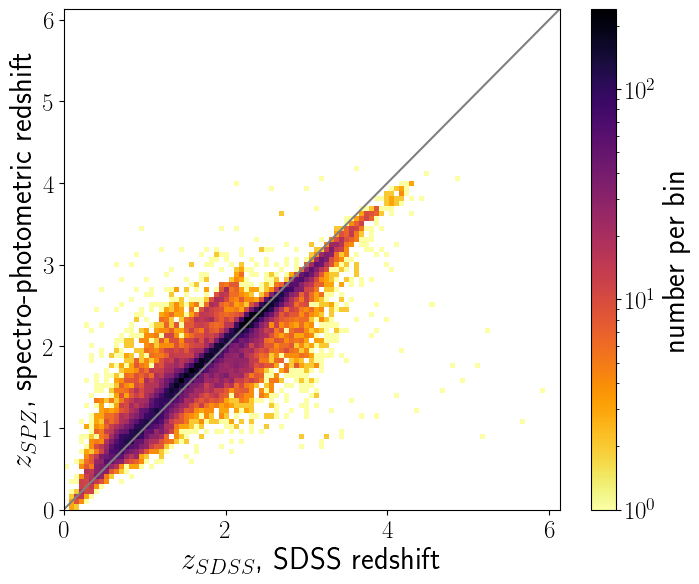

In [43]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spz_test_ANN, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

xx = np.linspace(np.min(z_bins), np.max(z_bins))
plt.plot(xx, xx, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

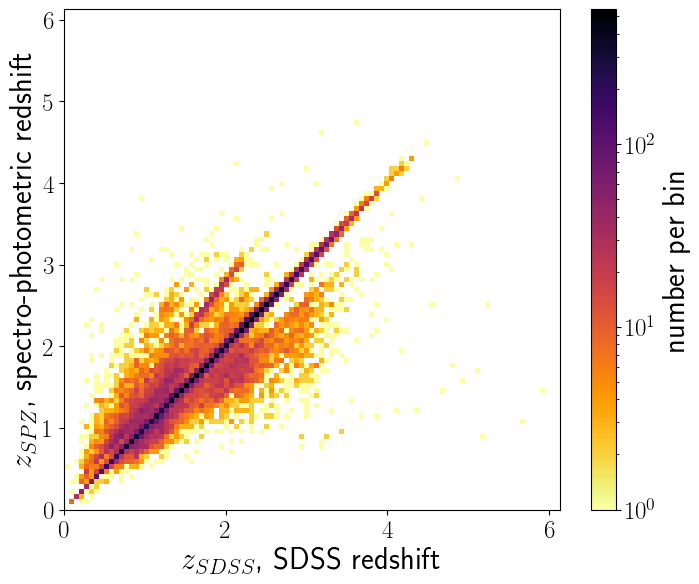

In [19]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spzqsoc_test_ANN, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{QSOC}$, QSOC redshift')

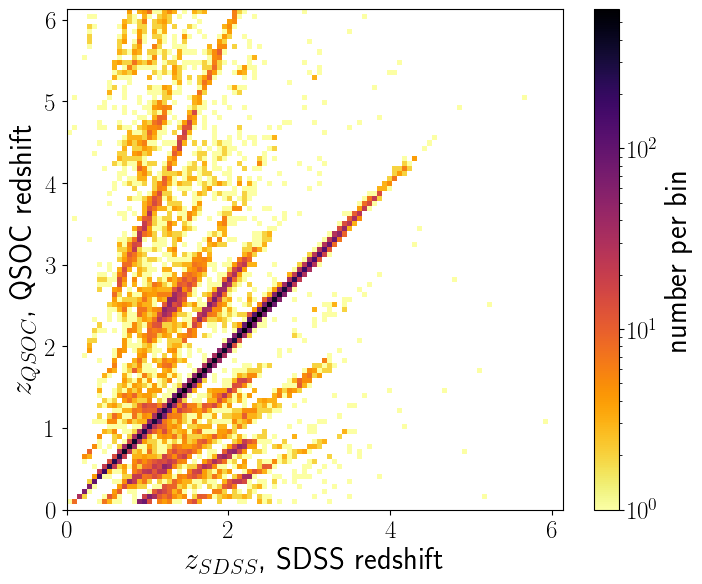

In [20]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_qsoc_test, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, QSOC redshift')

Text(0, 0.5, 'number per bin')

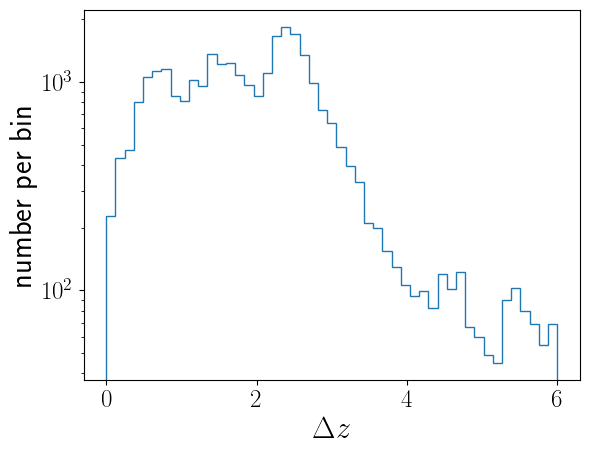

In [21]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(Y_qsoc_test, bins=np.linspace(0,6,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

Text(0, 0.5, 'number per bin')

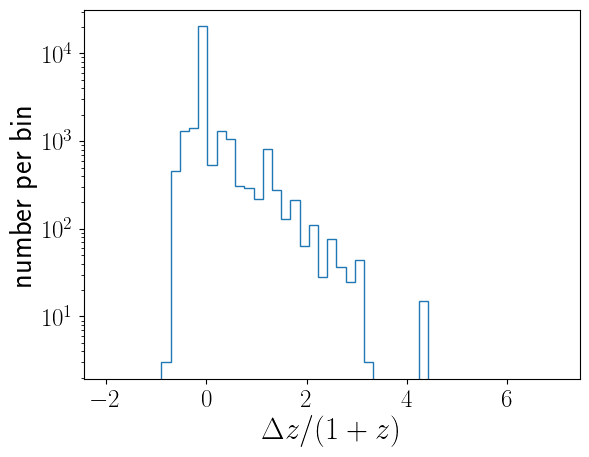

In [22]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist((Y_qsoc_test - Y_test)/(1+Y_test), bins=np.linspace(-2,7,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z/(1+z)$')
plt.ylabel('number per bin')

(-0.2, 0.2)

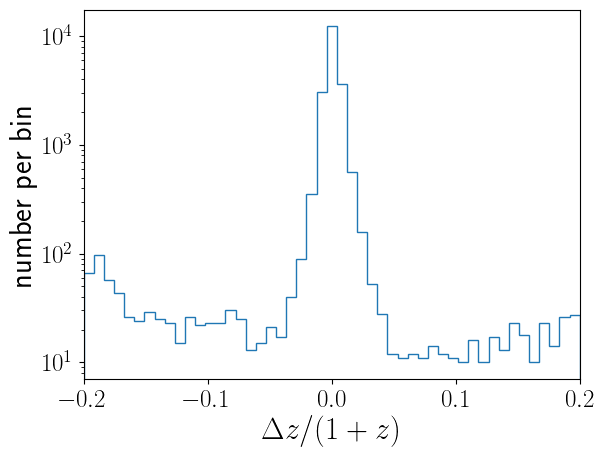

In [23]:
#plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist((Y_qsoc_test - Y_test)/(1+Y_test), bins=np.linspace(-0.2,0.2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z/(1+z)$')
plt.ylabel('number per bin')
plt.xlim(-0.2, 0.2)

## kNN

In [24]:
redshift_estimator_name = 'kNN'
G_max = 20.5
save_tag = '_regression'

In [25]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [26]:
tab_spz.columns

<TableColumns names=('redshift_qsoc','source_id','phot_g_mean_mag','sdss_OBJID','sdss_Z','rand_ints_clean','redshift_spz','redshift_spzqsoc','redshift_spz_err','chunk_spz')>

In [27]:
i_test = tab_spz['chunk_spz']=='test'
i_sort = np.argsort(tab_spz['source_id'][i_test])

In [28]:
Y_test = tab_spz['sdss_Z'][i_test][i_sort]
Y_spz_test_kNN = tab_spz['redshift_spz'][i_test][i_sort]
Y_spzqsoc_test_kNN = tab_spz['redshift_spzqsoc'][i_test][i_sort]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test][i_sort]

In [29]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test_kNN, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_spzqsoc = utils.get_fraction_recovered(Y_test, Y_spzqsoc_test_kNN, dz)
    print(f"SPZQSOC: {frac_recovered_spzqsoc:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.379
SPZQSOC: 0.636
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.826
SPZQSOC: 0.824
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.902
SPZQSOC: 0.899
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
SPZQSOC: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

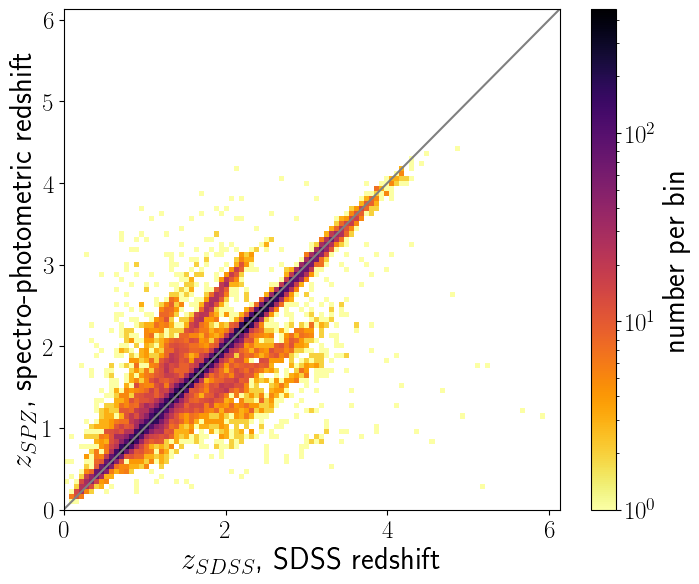

In [44]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spz_test_kNN, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

dz_min, dz_max = 0.2, 0.3
xx = np.linspace(0, np.max(tab_spz['redshift_qsoc']))
yy_min = dz_min*(1+xx) + xx
yy_max = dz_max*(1+xx) + xx
# plt.plot(xx, yy_min, color='grey')
# plt.plot(xx, yy_max, color='grey')


xx = np.linspace(np.min(z_bins), np.max(z_bins))
plt.plot(xx, xx, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

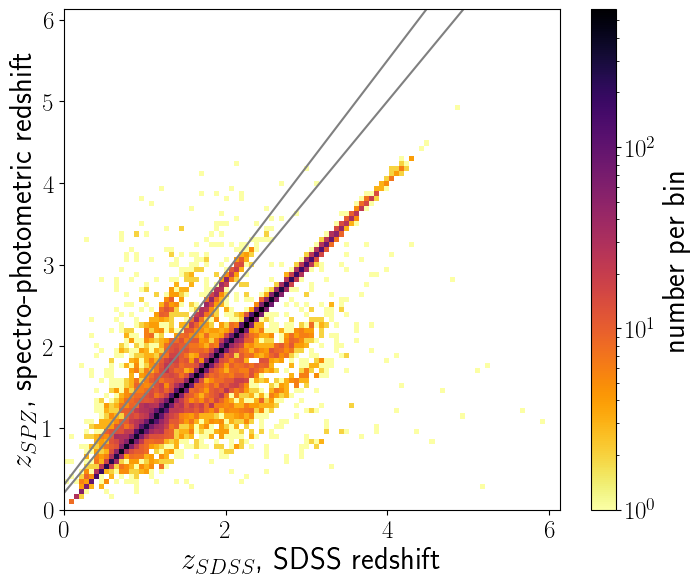

In [303]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spzqsoc_test_kNN, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

dz_min, dz_max = 0.2, 0.3
xx = np.linspace(0, np.max(tab_spz['redshift_qsoc']))
yy_min = dz_min*(1+xx) + xx
yy_max = dz_max*(1+xx) + xx
plt.plot(xx, yy_min, color='grey')
plt.plot(xx, yy_max, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [304]:
z_test_sdss = tab_spz['sdss_Z'][i_test]
z_test_spz = tab_spz['redshift_spz'][i_test]

In [305]:
dz_noabs = (z_test_spz - z_test_sdss)/(1 + z_test_sdss)

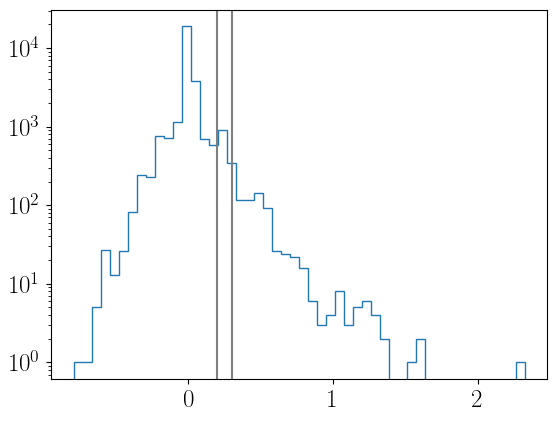

In [306]:
plt.hist(dz_noabs, histtype='step', bins=50)
plt.yscale('log')

plt.axvline(dz_min,color='grey')
plt.axvline(dz_max,color='grey')

In [307]:
i_inline = (dz_noabs>dz_min) & (dz_noabs<dz_max)
print(np.sum(i_inline))
print(np.sum(i_inline)/len(i_inline))

1216
0.04175537394409724


## Using kNN redshifts in ANN

In [103]:
redshift_estimator_name = 'ANN'
G_max = 20.5
#learning_rate = 0.005
#save_tag = f'_lr{learning_rate}_valid'
#save_tag = f'_regression_lr{learning_rate}'
#save_tag = f'_regression_wkNNspz_andqsoc_wmags'
save_tag = f'_regression_lr0.005_wkNNspz'
#save_tag = '_lr0.005'

In [104]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [105]:
fn_model = f'../data/redshift_models/model_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
redshift_estimator_class = redshift_estimator_dict[redshift_estimator_name]                        
redshift_estimator = redshift_estimator_class(train_mode=False, test_mode=False, feature_keys=None)
redshift_estimator.load_model(fn_model)

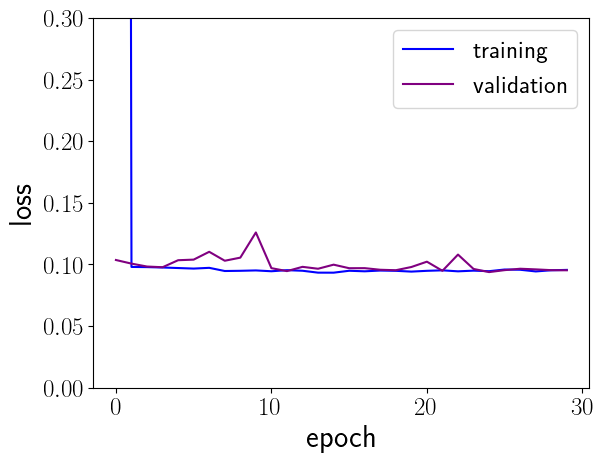

In [106]:
plt.plot(redshift_estimator.loss_train, color='blue', label='training')
plt.plot(redshift_estimator.loss_valid, color='purple', label='validation')
plt.ylim(0, 0.3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [107]:
i_test = tab_spz['chunk_spz']=='test'

In [108]:
len(tab_spz), X_gaia.shape

(1104830, (1104830, 8))

In [109]:
np.where(tab_spz['chunk_spz']=='test')

(array([     79,      93,      94, ..., 1103862, 1103903, 1103920]),)

In [110]:
i_sort = np.argsort(tab_spz['source_id'][i_test])

In [111]:
Y_test = tab_spz['sdss_Z'][i_test][i_sort]
Y_spz_test_ANNwk = tab_spz['redshift_spz'][i_test][i_sort]
Y_spzqsoc_test_ANNwk = tab_spz['redshift_spzqsoc'][i_test][i_sort]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test][i_sort]

In [112]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test_ANNwk, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_spzqsoc = utils.get_fraction_recovered(Y_test, Y_spz_test_ANNwk, dz)
    print(f"SPZQSOC: {frac_recovered_spzqsoc:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.192
SPZQSOC: 0.192
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.798
SPZQSOC: 0.798
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.916
SPZQSOC: 0.916
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
SPZQSOC: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

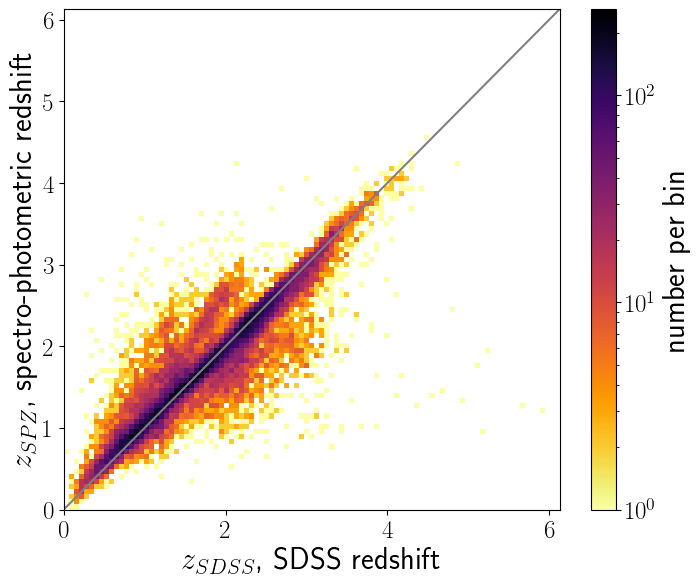

In [113]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spz_test_ANNwk, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

xx = np.linspace(np.min(z_bins), np.max(z_bins))
plt.plot(xx, xx, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

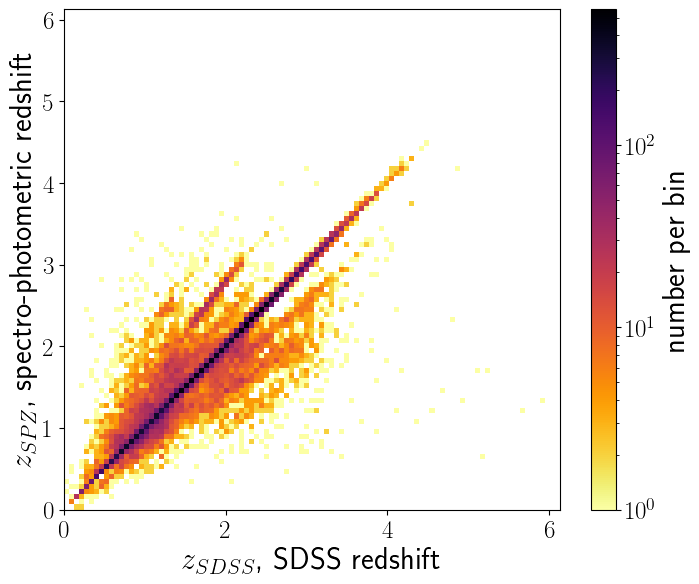

In [78]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spzqsoc_test_ANNwk, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

## Combine kNN and ANNwk with classifier

In [46]:
redshift_estimator_name = 'ANN2class'
G_max = 20.5
learning_rate = 0.005
#save_tag = f'_lr{learning_rate}_valid'
#save_tag = f'_regression_lr{learning_rate}'
save_tag = f'_combine_lr0.01_kNN_ANNwkwmags_wmags'
#save_tag = '_lr0.005'

In [47]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
#fn_spz = '../data/redshift_estimates/redshifts_spz_kNN_G20.5_combine_wANNspz_combine_lr0.005_wspzprevs_goodorbetter_wmags.fits'
tab_spz = Table.read(fn_spz, format='fits')
print(fn_spz)

../data/redshift_estimates/redshifts_spz_ANN2class_G20.5_combine_lr0.01_kNN_ANNwkwmags_wmags.fits


In [48]:
i_test = tab_spz['chunk_spz']=='test'

In [49]:
np.where(tab_spz['chunk_spz']=='test')

(array([     79,      93,      94, ..., 1103862, 1103903, 1103920]),)

In [50]:
i_sort = np.argsort(tab_spz['source_id'][i_test])

In [51]:
Y_test = tab_spz['sdss_Z'][i_test][i_sort]
Y_spz_test_comb = tab_spz['redshift_spz'][i_test][i_sort]
Y_spzqsoc_test_comb = tab_spz['redshift_spzqsoc'][i_test][i_sort]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test][i_sort]

In [52]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test_comb, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_spzqsoc = utils.get_fraction_recovered(Y_test, Y_spzqsoc_test_comb, dz)
    print(f"SPZQSOC: {frac_recovered_spzqsoc:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.332
SPZQSOC: 0.604
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.803
SPZQSOC: 0.802
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.920
SPZQSOC: 0.910
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 1.000
SPZQSOC: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

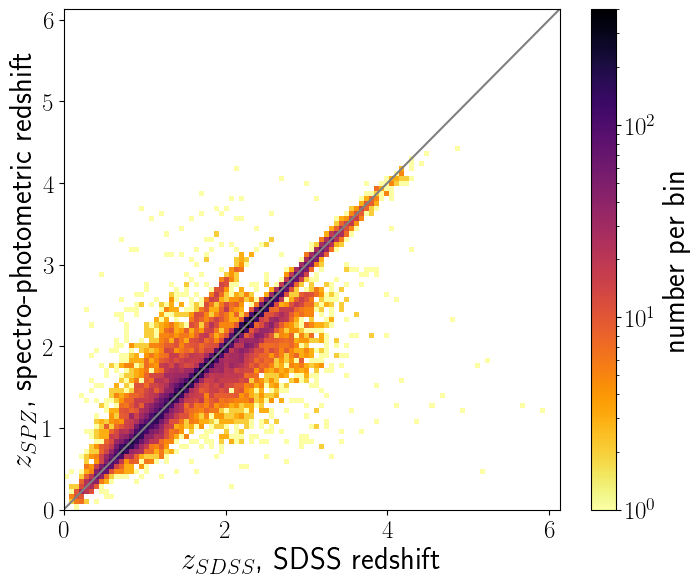

In [53]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spz_test_comb, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

xx = np.linspace(np.min(z_bins), np.max(z_bins))
plt.plot(xx, xx, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

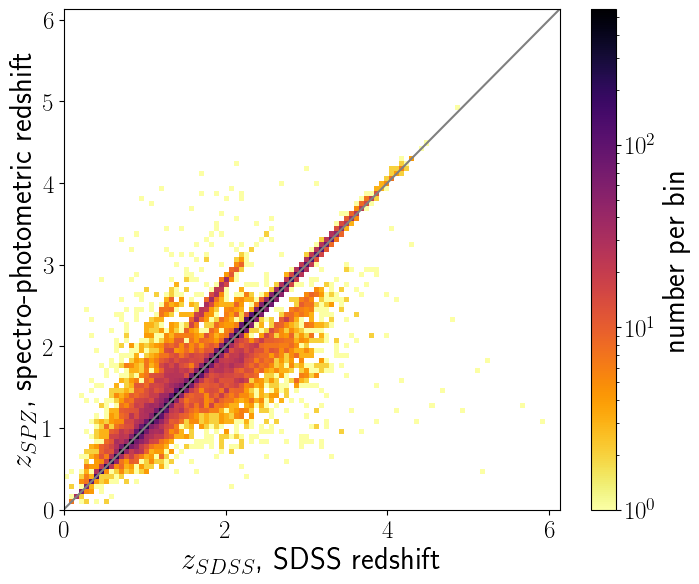

In [54]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spzqsoc_test_comb, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

xx = np.linspace(np.min(z_bins), np.max(z_bins))
plt.plot(xx, xx, color='grey')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

## Compare kNN and ANN results

In [114]:
dz_kNN = (Y_spz_test_kNN-Y_test)/(1+Y_test)
dz_ANN = (Y_spz_test_ANN-Y_test)/(1+Y_test)
dz_ANNwk = (Y_spz_test_ANNwk-Y_test)/(1+Y_test)
dz_qsoc = (Y_qsoc_test-Y_test)/(1+Y_test)
dz_comb = (Y_spz_test_comb-Y_test)/(1+Y_test)

In [115]:
dz_thresh_kNN_ANNwk_agree = 0.08
dz_kNN_ANNwk_agree = (Y_spz_test_ANNwk-Y_spz_test_kNN)/(1+Y_spz_test_kNN)
i_kNN_ANNwk_agree = np.abs(dz_kNN_ANNwk_agree) < dz_thresh_kNN_ANNwk_agree
Y_spz_test_kNN_ANNwk = Y_spz_test_ANNwk.copy()
print(len(Y_spz_test_kNN_ANNwk))
print(len(i_kNN_ANNwk_agree))
print(np.sum(i_kNN_ANNwk_agree))
Y_spz_test_kNN_ANNwk[i_kNN_ANNwk_agree] = Y_spz_test_kNN[i_kNN_ANNwk_agree]
dz_kNN_ANNwk = (Y_spz_test_kNN_ANNwk-Y_test)/(1+Y_test)

29122
29122
27000


In [116]:
Y_spz_test_kNN_ANNwk_v2 = Y_spz_test_ANNwk.copy()
i_ANN_lessthan_kNN = Y_spz_test_ANNwk < Y_spz_test_kNN
print(np.sum(i_ANN_lessthan_kNN), len(i_ANN_lessthan_kNN))
Y_spz_test_kNN_ANNwk_v2[i_ANN_lessthan_kNN] = Y_spz_test_kNN[i_ANN_lessthan_kNN]
dz_kNN_ANNwk_v2 = (Y_spz_test_kNN_ANNwk_v2-Y_test)/(1+Y_test)

13205 29122


In [135]:
dz_thresh_good = 0.1
frac_good_best = 0
frac_goods = []
weights = np.linspace(0, 1, 101)
weight_best = np.nan
for weight in weights:
    Y_spz_weighted = weight*Y_spz_test_kNN + (1-weight)*Y_spz_test_ANNwk
    frac_good = utils.get_fraction_recovered(Y_test, Y_spz_weighted, dz_thresh_good)
    #dz_weighted = (Y_spz_weighted-Y_test)/(1+Y_test)
    #i_good = np.abs(dz_weighted) < dz_thresh_good
    #frac_good = 
    frac_goods.append(frac_good)
    if frac_good > frac_good_best:
        frac_good_best = frac_good
        weight_best = weight
print(weight_best, frac_good_best)

0.96 0.8264885653457867


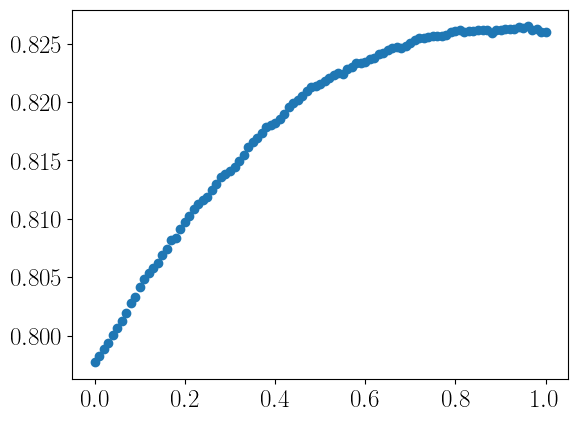

In [136]:
#plt.hist(frac_goods)
plt.scatter(weights, frac_goods)

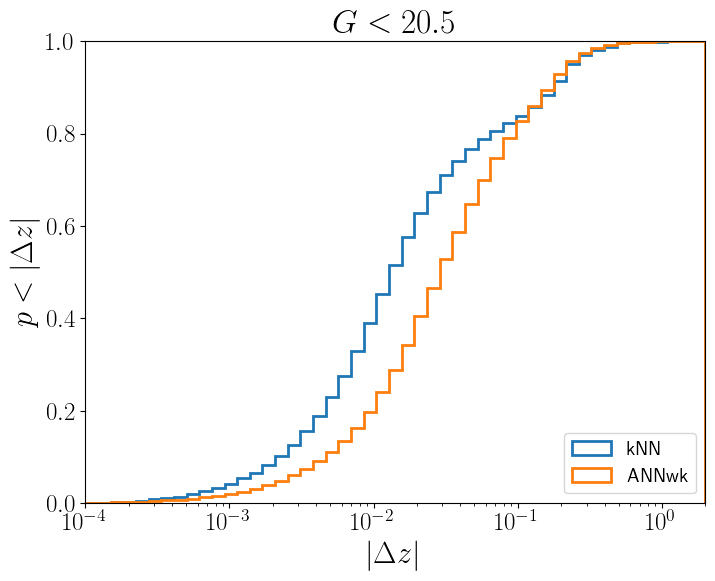

In [148]:
plt.figure(figsize=(8,6))
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(dz_kNN), label='kNN',
         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True, lw=2)
#plt.hist(abs(dz_ANN), label='ANN',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.hist(abs(dz_ANNwk), label='ANNwk',
         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True, lw=2)
#plt.hist(abs(dz_qsoc), label='qsoc',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
#plt.hist(abs(dz_kNN_ANNwk), label='kNN/ANNwk',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
#plt.hist(abs(dz_comb), label='kNN/ANNwk\nclass.',
#        bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=14)

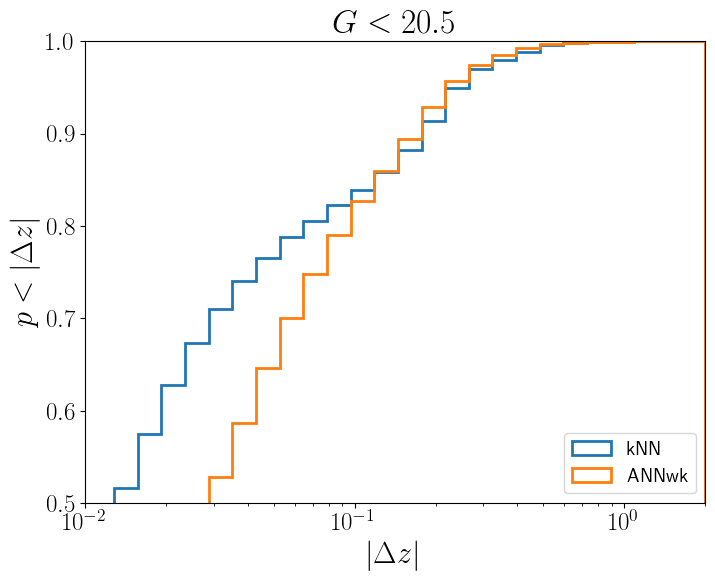

In [149]:
plt.figure(figsize=(8,6))
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(dz_kNN), label='kNN',
         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True, lw=2)
#plt.hist(abs(dz_ANN), label='ANN',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.hist(abs(dz_ANNwk), label='ANNwk',
         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True, lw=2)
#plt.hist(abs(dz_qsoc), label='qsoc',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
#plt.hist(abs(dz_kNN_ANNwk), label='kNN/ANNwk',
#         bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
#plt.hist(abs(dz_comb), label='kNN/ANNwk\nclass.',
#        bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
#plt.yscale('log')
plt.xlim(1e-2, 2)
plt.ylim(0.5,1)
plt.legend(loc='lower right', fontsize=14)

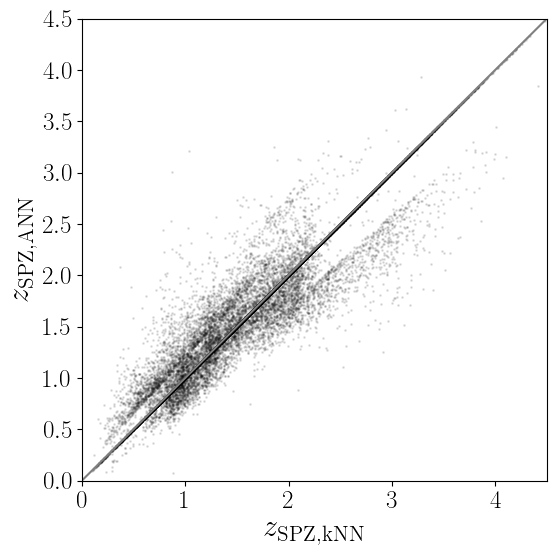

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(Y_spzqsoc_test_kNN, Y_spzqsoc_test_ANN, color='k', alpha=0.1, s=1)
plt.xlabel(r'$z_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$z_\mathrm{SPZ,ANN}$')

plt.xlim(0, 4.5)
plt.ylim(0, 4.5)
xx = np.linspace(0,4.5, 2)
yy = xx
plt.plot(xx, yy, color='grey')

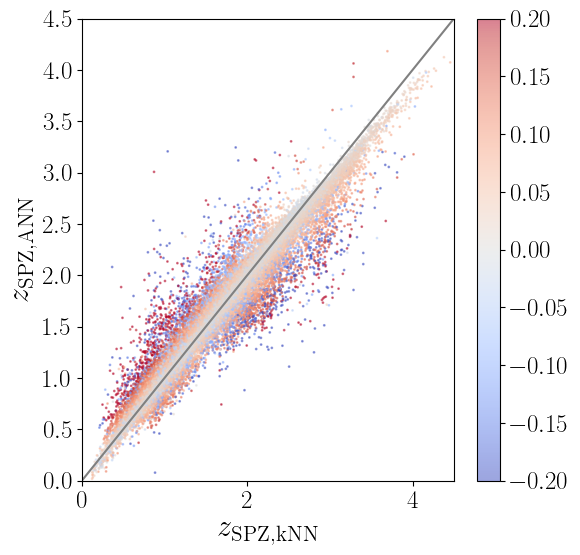

In [203]:
plt.figure(figsize=(6,6))
plt.scatter(Y_spz_test_kNN, Y_spz_test_ANN, c=np.abs(dz_ANN)-np.abs(dz_kNN), alpha=0.5, s=1, 
            cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.xlabel(r'$z_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$z_\mathrm{SPZ,ANN}$')

plt.xlim(0, 4.5)
plt.ylim(0, 4.5)
xx = np.linspace(0,4.5, 2)
yy = xx
plt.plot(xx, yy, color='grey')

plt.colorbar()

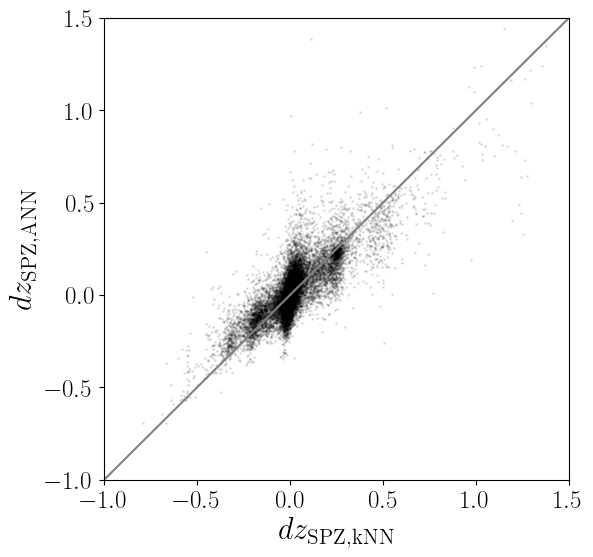

In [37]:
plt.figure(figsize=(6,6))

dz_kNN = (Y_spz_test_kNN-Y_test)/(1+Y_test)
dz_ANN = (Y_spz_test_ANN-Y_test)/(1+Y_test)
plt.scatter(dz_kNN, dz_ANN, color='k', alpha=0.1, s=1)
plt.xlabel(r'$dz_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$dz_\mathrm{SPZ,ANN}$')
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)
xx = np.linspace(-1, 1.5, 2)
yy = xx
plt.plot(xx, yy, color='grey')

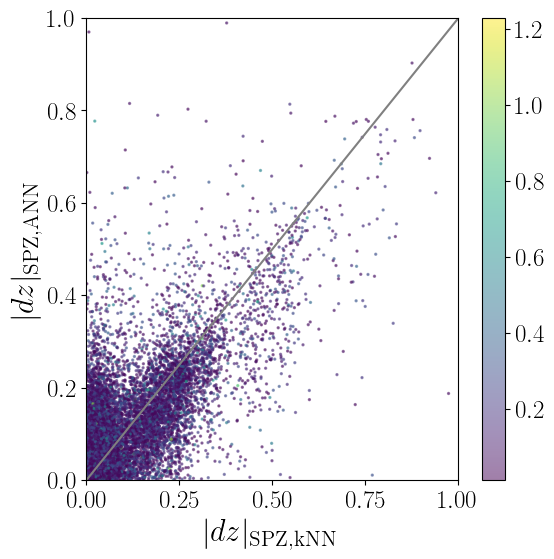

In [38]:
plt.figure(figsize=(6,6))

plt.scatter(np.abs(dz_kNN), np.abs(dz_ANN), c=tab_spz['redshift_spz_err'][i_test], alpha=0.5, s=2)
plt.xlabel(r'$|dz|_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
xx = np.linspace(0, 1, 2)
yy = xx
plt.plot(xx, yy, color='grey')
plt.colorbar()

Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN}$')

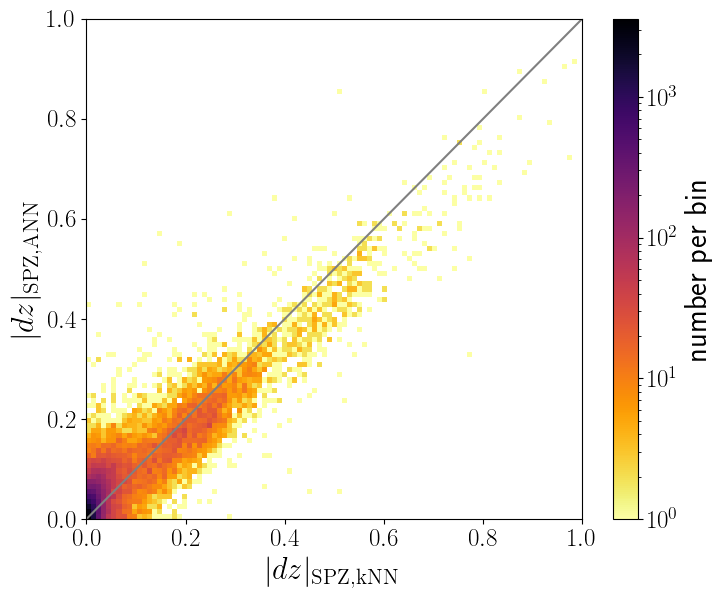

In [146]:
z_bins = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(np.abs(dz_kNN), np.abs(dz_ANNwk),
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

xx = np.linspace(0, 1, 2)
yy = xx
plt.plot(xx, yy, color='grey')

plt.xlabel(r'$|dz|_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN}$')

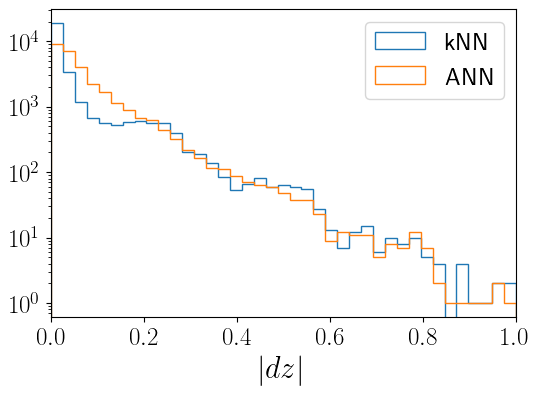

In [55]:
bins = np.linspace(0, 1, 40)
plt.figure(figsize=(6,4))
plt.hist(np.abs(dz_kNN), histtype='step', bins=bins, label='kNN') 
plt.hist(np.abs(dz_ANN), histtype='step', bins=bins, label='ANN')
plt.xlabel(r'$|dz|$')
plt.xlim(0, 1)
plt.yscale('log')
plt.legend()

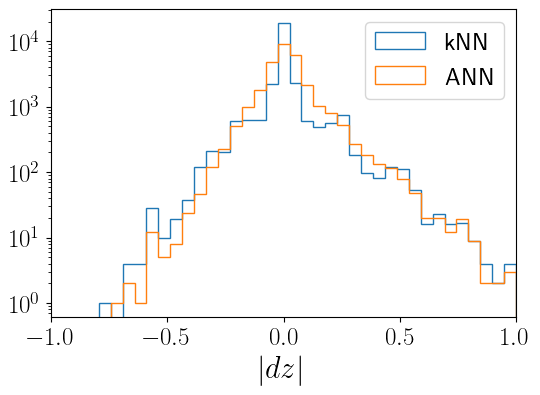

In [56]:
bins = np.linspace(-1, 1, 40)
plt.figure(figsize=(6,4))
plt.hist(dz_kNN, histtype='step', bins=bins, label='kNN') 
plt.hist(dz_ANN, histtype='step', bins=bins, label='ANN')
plt.xlabel(r'$|dz|$')
plt.xlim(-1, 1)
plt.yscale('log')
plt.legend()

In [40]:
i_ANN_better = np.abs(dz_ANN) < np.abs(dz_kNN)
print(np.sum(i_ANN_better), np.sum(i_ANN_better)/len(i_ANN_better))

8083 0.2775564865050477


In [41]:
dz_thresh = 0.2

In [42]:
i_kNN_bad = np.abs(dz_kNN) > dz_thresh
print(np.sum(i_kNN_bad), len(i_kNN_bad))
print(np.sum(i_kNN_bad)/len(i_kNN_bad))

2848 29122
0.09779548107959618


In [43]:
print(np.sum(i_kNN_bad & i_ANN_better), np.sum(i_kNN_bad & i_ANN_better)/len(i_kNN_bad & i_ANN_better))

2259 0.07757022182542408


In [44]:
i_ANN_good = np.abs(dz_ANN) < dz_thresh
print(np.sum(i_ANN_good & i_ANN_better), np.sum(i_ANN_good & i_ANN_better)/len(i_ANN_good & i_ANN_better))

6875 0.23607581896847743


In [45]:
print(np.sum(i_ANN_good & i_kNN_bad), np.sum(i_ANN_good & i_kNN_bad)/len(i_ANN_good & i_kNN_bad))

1051 0.03608955428885379


In [151]:
i_ANNwk_better = np.abs(dz_ANNwk) < np.abs(dz_kNN)
print(np.sum(i_ANNwk_better), np.sum(i_ANNwk_better)/len(i_ANNwk_better))

9714 0.3335622553396058


Text(0, 0.5, '$\\sigma_\\mathrm{SPZ,kNN}$')

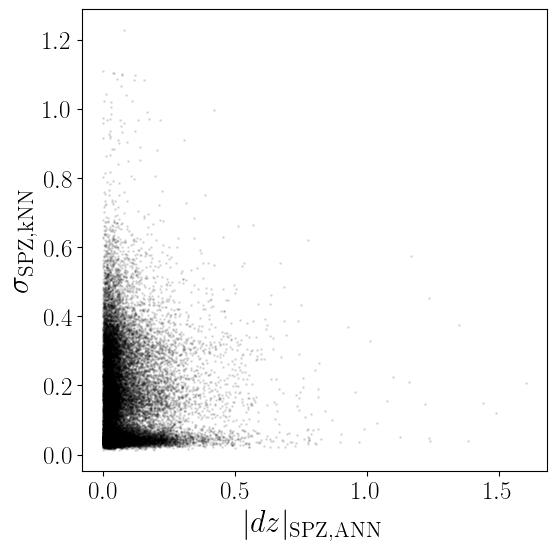

In [46]:
plt.figure(figsize=(6,6))
plt.scatter(np.abs(dz_ANN), tab_spz['redshift_spz_err'][i_test], color='k', alpha=0.1, s=1)
plt.xlabel(r'$|dz|_\mathrm{SPZ,ANN}$')
plt.ylabel(r'$\sigma_\mathrm{SPZ,kNN}$')

Text(0, 0.5, '$\\sigma_\\mathrm{SPZ,kNN}$')

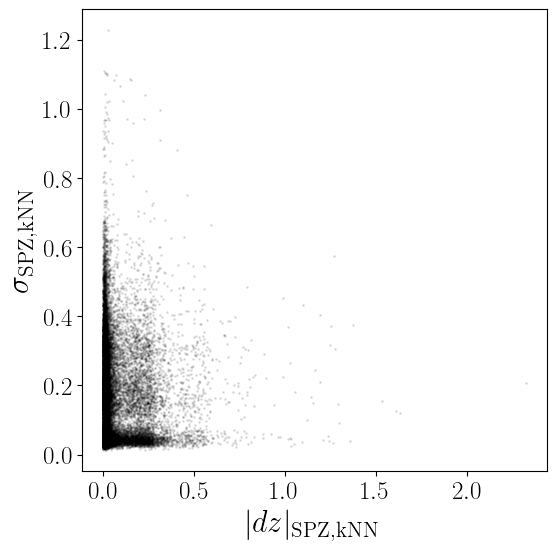

In [47]:
plt.figure(figsize=(6,6))
plt.scatter(np.abs(dz_kNN), tab_spz['redshift_spz_err'][i_test], color='k', alpha=0.1, s=1)
plt.xlabel(r'$|dz|_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$\sigma_\mathrm{SPZ,kNN}$')

Text(0, 0.5, '$\\sigma_\\mathrm{SPZ,kNN}$')

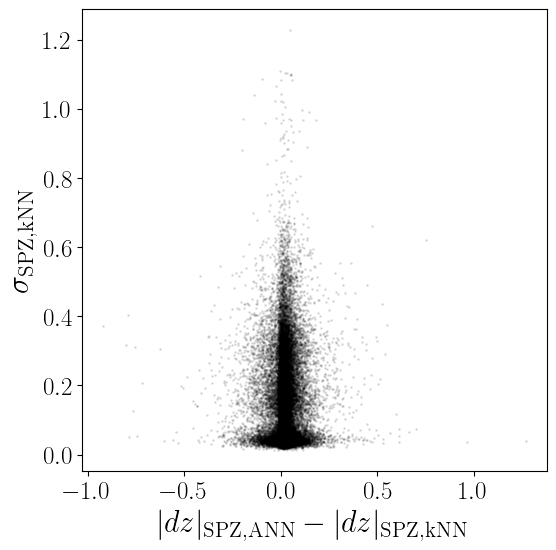

In [48]:
plt.figure(figsize=(6,6))
plt.scatter(np.abs(dz_ANN)-np.abs(dz_kNN), tab_spz['redshift_spz_err'][i_test], color='k', alpha=0.1, s=1)
plt.xlabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$\sigma_\mathrm{SPZ,kNN}$')

Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN} - |dz|_\\mathrm{SPZ,kNN}$')

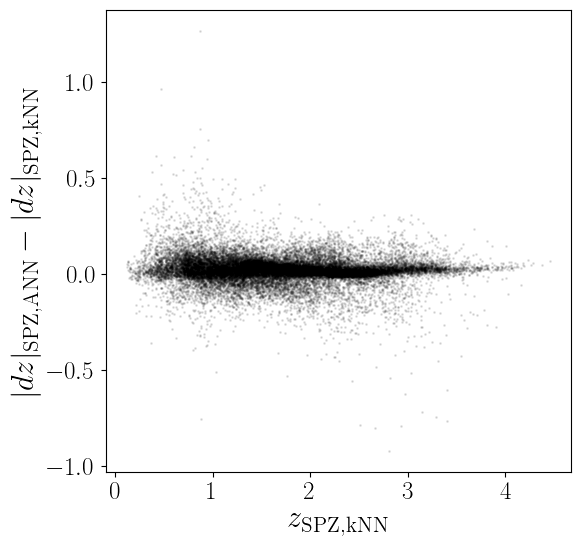

In [49]:
plt.figure(figsize=(6,6))
plt.scatter(Y_spz_test_kNN, np.abs(dz_ANN)-np.abs(dz_kNN), color='k', alpha=0.1, s=1)
plt.xlabel(r'$z_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')


Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN} - |dz|_\\mathrm{SPZ,kNN}$')

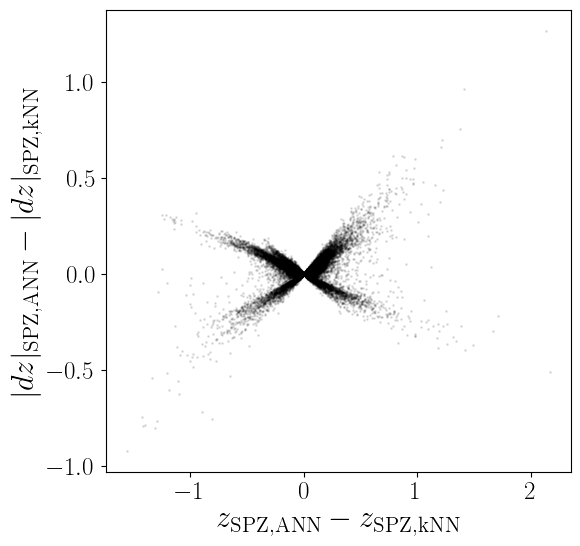

In [50]:
plt.figure(figsize=(6,6))
plt.scatter(Y_spz_test_ANN-Y_spz_test_kNN, np.abs(dz_ANN)-np.abs(dz_kNN), color='k', alpha=0.1, s=1)
plt.xlabel(r'$z_\mathrm{SPZ,ANN} - z_\mathrm{SPZ,kNN}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')

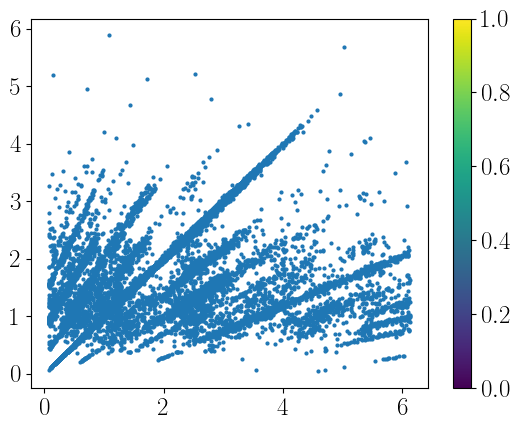

In [71]:
plt.scatter(X_gaia[i_test][i_sort][:,0], Y_test, s=4)
            #c=np.abs(dz_ANN)-np.abs(dz_kNN), cmap='coolwarm', vmin=-0.3, vmax=0.3)
plt.colorbar()

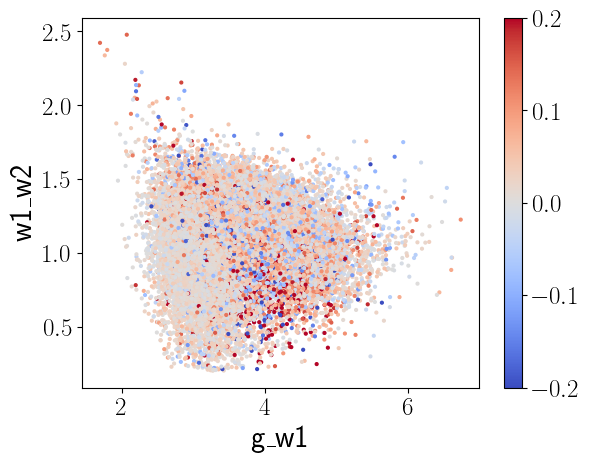

In [78]:
i_feat1, i_feat2 = 5, 6
plt.scatter(X_gaia[i_test][i_sort][:,i_feat1], X_gaia[i_test][i_sort][:,i_feat2], s=4, 
            c=np.abs(dz_ANN)-np.abs(dz_kNN), cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.xlabel(feature_keys[i_feat1])
plt.ylabel(feature_keys[i_feat2])
plt.colorbar()

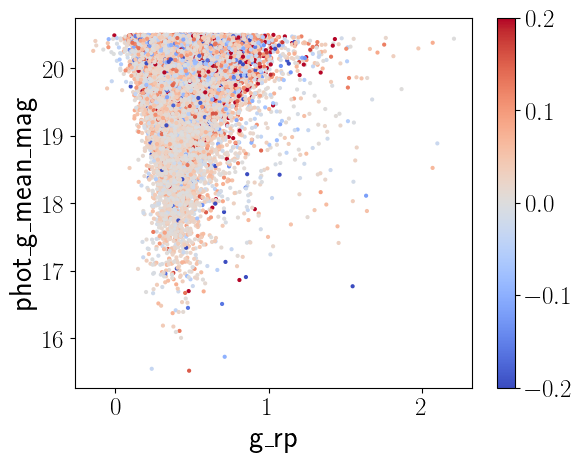

In [77]:
i_feat1, i_feat2 = 2, 7
plt.scatter(X_gaia[i_test][i_sort][:,i_feat1], X_gaia[i_test][i_sort][:,i_feat2], s=4, 
            c=np.abs(dz_ANN)-np.abs(dz_kNN), cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.xlabel(feature_keys[i_feat1])
plt.ylabel(feature_keys[i_feat2])
plt.colorbar()

In [ ]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(delta_z), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, '$|dz|$')

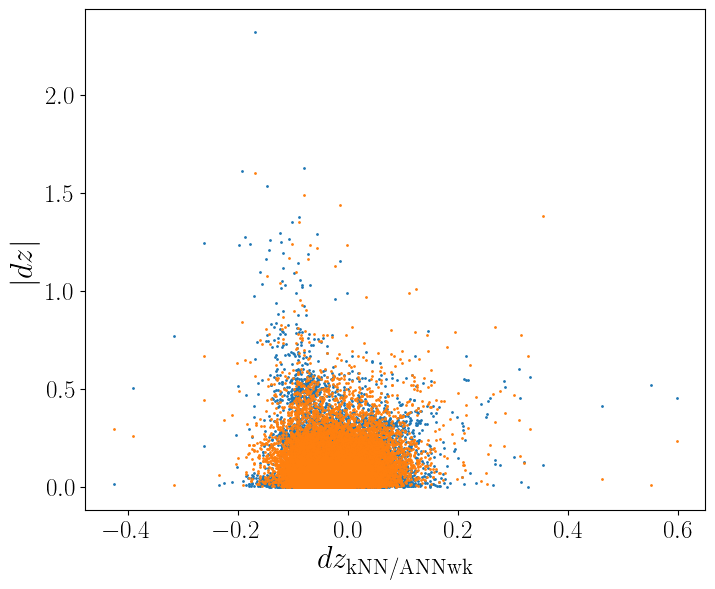

In [192]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.scatter(dz_kNN_ANNwk_agree, np.abs(dz_kNN),s=1)
h = ax.scatter(dz_kNN_ANNwk_agree, np.abs(dz_ANN),s=1)

plt.xlabel(r'$dz_\mathrm{kNN/ANNwk}$')
plt.ylabel(r'$|dz|$')

Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN} - |dz|_\\mathrm{SPZ,kNN}$')

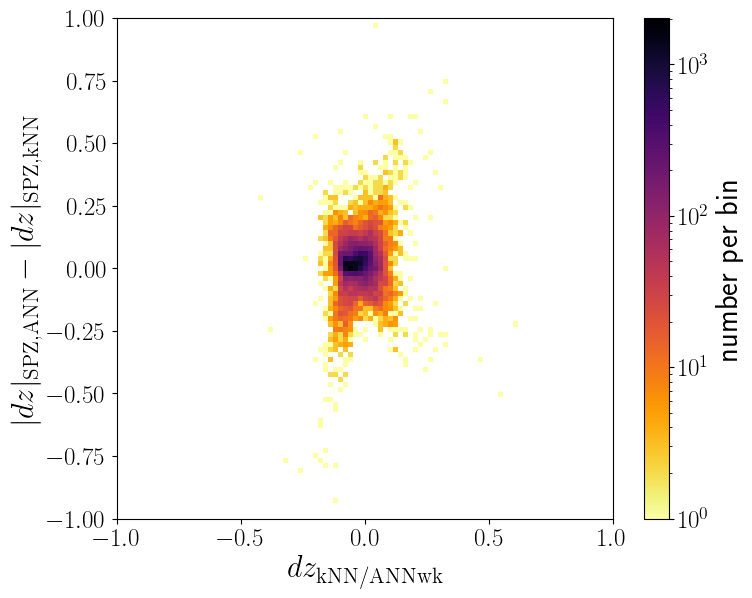

In [188]:
z_bins = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(dz_kNN_ANNwk_agree, np.abs(dz_ANN)-np.abs(dz_kNN),
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$dz_\mathrm{kNN/ANNwk}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')

Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN} - |dz|_\\mathrm{SPZ,kNN}$')

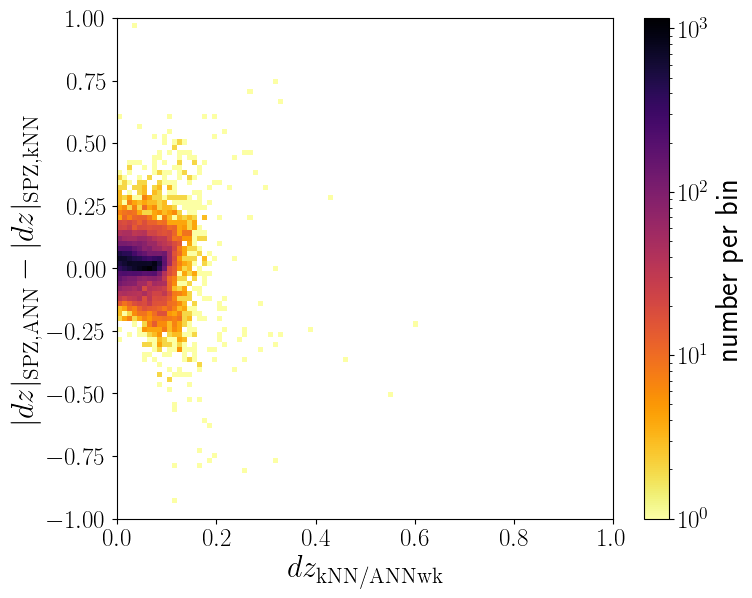

In [212]:
dz_bins = np.linspace(0, 1, 100)
z_bins = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(np.abs(dz_kNN_ANNwk_agree), np.abs(dz_ANN)-np.abs(dz_kNN),
              bins=(dz_bins, z_bins), cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$dz_\mathrm{kNN/ANNwk}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')

Text(0, 0.5, '$|dz|_\\mathrm{SPZ,ANN} - |dz|_\\mathrm{SPZ,kNN}$')

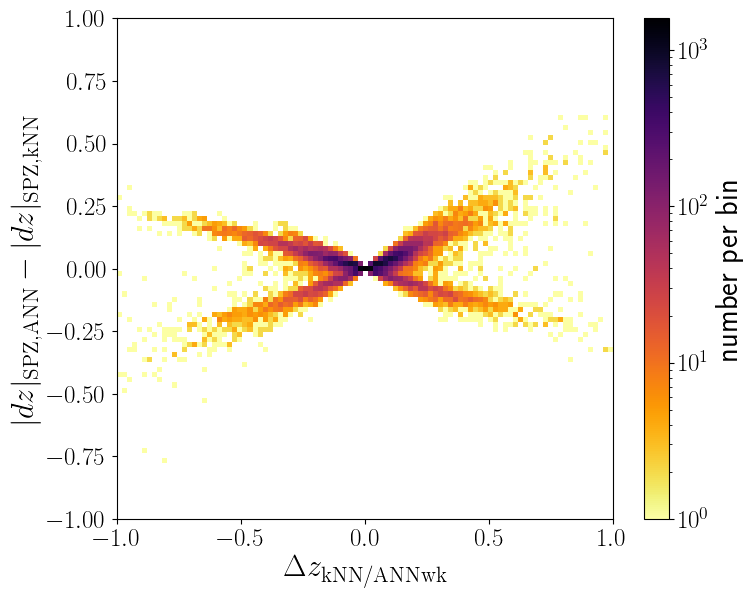

In [194]:
z_bins = np.linspace(-1, 1, 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_spz_test_ANN-Y_spz_test_kNN, np.abs(dz_ANN)-np.abs(dz_kNN),
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$\Delta z_\mathrm{kNN/ANNwk}$')
plt.ylabel(r'$|dz|_\mathrm{SPZ,ANN} - |dz|_\mathrm{SPZ,kNN}$')

In [ ]:
# positive y: kNN error smaller than ANN error, so choose kNN
# this happens more. when dz>0, so when >0 choose kNN. when <0 choose ANN

## Combined

In [60]:
redshift_estimator_name = 'kNN'
G_max = 20.5
learning_rate = 0.005
save_tag = '_combine_wANNspz_combine_lr0.005_wspzprevs_goodorbetter_wmags'
#save_tag = '_lr0.005'

In [61]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
#fn_spz = '../data/redshift_estimates/redshifts_spz_kNN_G20.5_combine_wANNspz_combine_lr0.005_wspzprevs_goodorbetter_wmags.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [62]:
i_test = tab_spz['chunk_spz']=='test'

In [63]:
Y_test = tab_spz['sdss_Z'][i_test]
Y_spz_test_ANN = tab_spz['redshift_spz'][i_test]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test]

In [64]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test_ANN, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.570
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.811
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.896
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

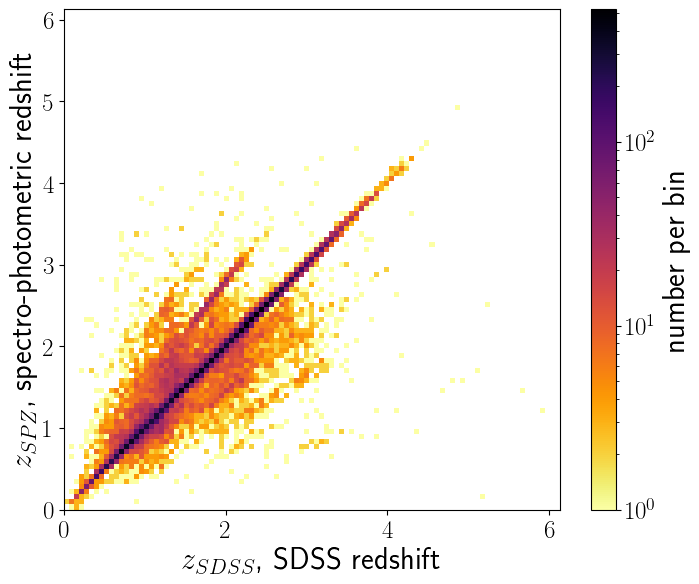

In [65]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(Y_test, Y_spz_test_ANN, 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

## ANN Dz/(1+z) loss

In [175]:
redshift_estimator_name = 'ANN'
G_max = 20.5
save_tag = '_valid_lossdz'

In [176]:
fn_spz = f'../data/redshift_estimates/redshifts_spz_{redshift_estimator_name}_G{G_max}{save_tag}.fits'
tab_spz = Table.read(fn_spz, format='fits')

In [177]:
i_test = tab_spz['chunk_spz']=='test'

In [178]:
Y_test = tab_spz['sdss_Z'][i_test]
Y_spz_test = tab_spz['redshift_spz'][i_test]
Y_qsoc_test = tab_spz['redshift_qsoc'][i_test]

In [179]:
dzs = [0.01, 0.1, 0.2, 1.0]
for dz in dzs:
    print(f"Fraction recovered with Dz/(1+z)<{dz}:")
    frac_recovered = utils.get_fraction_recovered(Y_test, Y_spz_test, dz)
    print(f"SPZ: {frac_recovered:.3f}")
    frac_recovered_qsoc = utils.get_fraction_recovered(Y_test, Y_qsoc_test, dz)
    print(f"QSOC: {frac_recovered_qsoc:.3f}")

Fraction recovered with Dz/(1+z)<0.01:
SPZ: 0.055
QSOC: 0.627
Fraction recovered with Dz/(1+z)<0.1:
SPZ: 0.528
QSOC: 0.704
Fraction recovered with Dz/(1+z)<0.2:
SPZ: 0.787
QSOC: 0.727
Fraction recovered with Dz/(1+z)<1.0:
SPZ: 0.999
QSOC: 0.933


Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

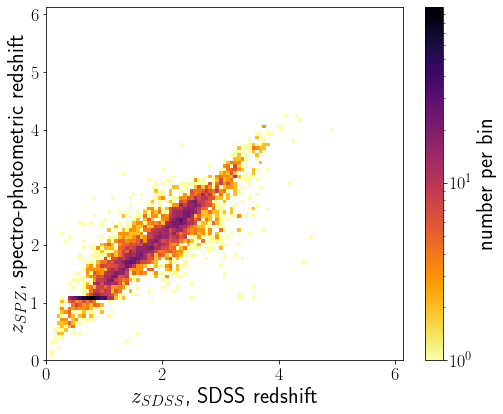

In [180]:
z_bins = np.linspace(0, np.max(tab_spz['redshift_qsoc']), 100)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_spz['sdss_Z'][i_test], tab_spz['redshift_spz'][i_test], 
              bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

# All data

In [89]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia = Table.read('../data/gaia_slim_xsdss.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia))

Total number of Gaia quasars: 6649162


In [90]:
tab_spz_slim = tab_spz.copy()
tab_spz_slim.keep_columns(['source_id', 'redshift_spz'])
tab_gaia = astropy.table.join(tab_gaia, tab_spz_slim, keys='source_id', join_type='left')

In [91]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','rand_ints','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','pm','sdss_SDSS_NAME','sdss_OBJID','sdss_THING_ID','sdss_RA','sdss_DEC','sdss_Z','redshift_spz')>

In [92]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

1104830

In [93]:
idx_withsdss = np.isfinite(tab_gaia['sdss_Z'])
np.sum(idx_withsdss)

327096

In [94]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

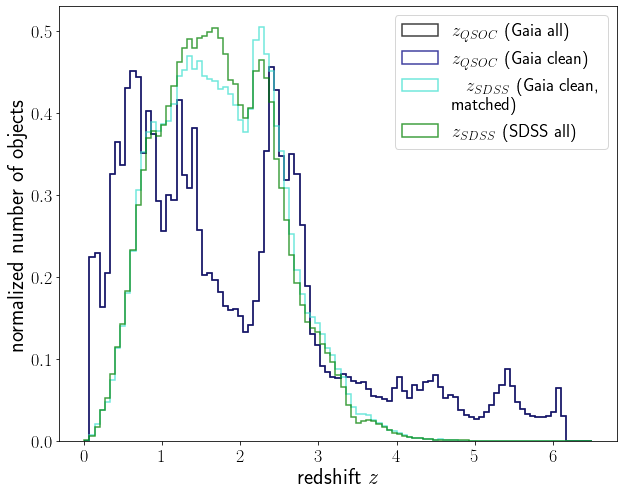

In [97]:
alpha = 0.75
lw = 1.5
density = True
histtype='step'
z_bins = np.linspace(0,6.5,100)

plt.figure(figsize=(10,8))
_ = plt.hist(tab_gaia['redshift_qsoc'], bins=z_bins, alpha=alpha, color='k', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia all)')
_ = plt.hist(tab_gaia['redshift_qsoc'][idx_withspz], bins=z_bins, alpha=alpha, color='navy', lw=lw,
             density=density, histtype=histtype, label=r'$z_{QSOC}$ (Gaia clean)')
# _ = plt.hist(tab_gaia['redshift_spz'], bins=z_bins, alpha=alpha, color='m', lw=lw, 
#              density=density, histtype=histtype, label=r'$z_{SPZ}$ (Gaia clean)')
_ = plt.hist(tab_gaia['sdss_Z'], bins=z_bins, alpha=alpha, color='turquoise', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (Gaia clean,\\matched)')
_ = plt.hist(tab_sdss['Z'], bins=z_bins, alpha=alpha, color='g', lw=lw,
             density=density, histtype=histtype, label=r'$z_{SDSS}$ (SDSS all)')
plt.xlabel(r'redshift $z$')
plt.ylabel('normalized number of objects')
plt.legend()

Text(0, 0.5, '$z_{QSOC}$, Gaia QSOC redshift')

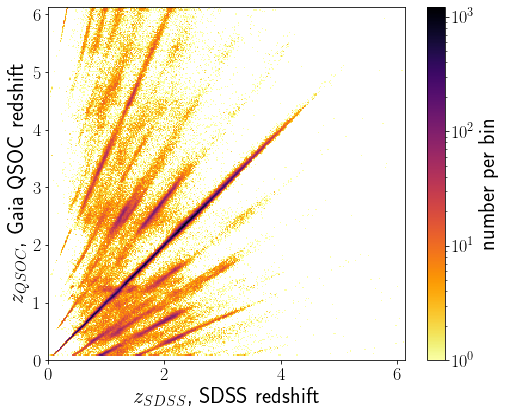

In [99]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['sdss_Z'], tab_gaia['redshift_qsoc'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{QSOC}$, Gaia QSOC redshift')

In [100]:
def get_fraction_recovered(Y_true, Y_hat, z_err_close):
    return np.sum(np.abs(Y_true - Y_hat) < z_err_close) / len(Y_true)

def mse(Y_true, Y_hat):
    return np.mean((Y_true - Y_hat)**2, axis=0)

Text(0, 0.5, '$z_{SPZ}$, spectro-photometric redshift')

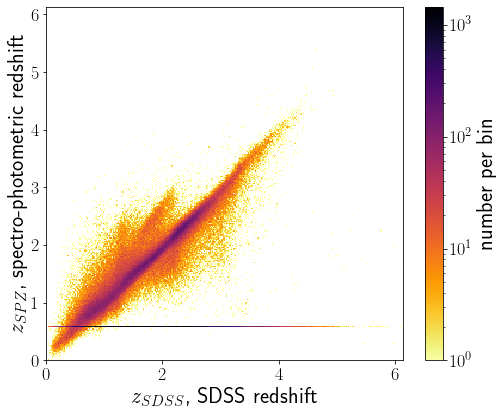

In [102]:
z_bins = np.linspace(0, np.max(tab_gaia['redshift_qsoc']), 300)
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(tab_gaia['sdss_Z'], tab_gaia['redshift_spz'], bins=z_bins, cmin=1, cmap='inferno_r',
             norm=matplotlib.colors.LogNorm())
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_{SPZ}$, spectro-photometric redshift')

In [104]:
mse_spz = mse(tab_gaia['sdss_Z'][idx_withsdss], tab_gaia['redshift_spz'][idx_withsdss])
mse_baseline = mse(tab_gaia['sdss_Z'][idx_withsdss], tab_gaia['redshift_qsoc'][idx_withsdss])
print(f"MSE: {mse_spz:.3f} (Baseline: {mse_baseline:.3f})")

MSE: 0.096 (Baseline: 1.347)


In [107]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['sdss_Z'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with Dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  327096
Fraction recovered with Dz<0.1: 0.288
(Baseline: 0.592)
Fraction recovered with Dz<0.2: 0.421
(Baseline: 0.602)


In [108]:
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['sdss_Z'][idx_withsdss]))
for z_err_close in z_errs_close:
    frac_recovered = utils.get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_spz'][idx_withsdss], z_err_close)
    frac_recovered_baseline = utils.get_fraction_recovered(tab_gaia['sdss_Z'][idx_withsdss], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss], z_err_close)
    print(rf"Fraction recovered with dz<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  327096
Fraction recovered with dz<0.1: 0.452
(Baseline: 0.604)
Fraction recovered with dz<0.2: 0.538
(Baseline: 0.637)


# G<20 only

In [21]:
G_max = 20
idx_G = tab_gaia['phot_g_mean_mag'][idx_withsdss] < G_max
z_errs_close = [0.1, 0.2]
print("Number of test objects: ", len(tab_gaia['redshift_sdss'][idx_withsdss][idx_G]))
for z_err_close in z_errs_close:
    frac_recovered = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_spz'][idx_withsdss][idx_G], z_err_close)
    frac_recovered_baseline = get_fraction_recovered(tab_gaia['redshift_sdss'][idx_withsdss][idx_G], 
                                            tab_gaia['redshift_qsoc'][idx_withsdss][idx_G], z_err_close)
    print(rf"Fraction recovered with $\delta z$<{z_err_close}: {frac_recovered:.3f}")
    print(rf"(Baseline: {frac_recovered_baseline:.3f})")

Number of test objects:  168065
Fraction recovered with $\delta z$<0.1: 0.742
(Baseline: 0.818)
Fraction recovered with $\delta z$<0.2: 0.862
(Baseline: 0.823)


## Cumulative dist

In [22]:
delta_z = tab_gaia['redshift_sdss'][idx_withsdss] - tab_gaia['redshift_spz'][idx_withsdss]
delta_z_G = tab_gaia['redshift_sdss'][idx_withsdss][idx_G] - tab_gaia['redshift_spz'][idx_withsdss][idx_G]

Text(0, 0.5, 'number per bin')

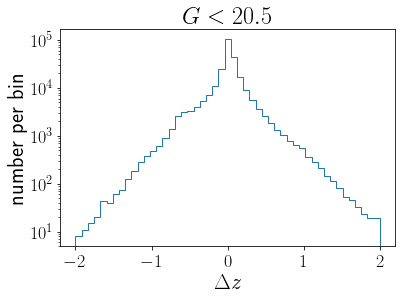

In [23]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(delta_z, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

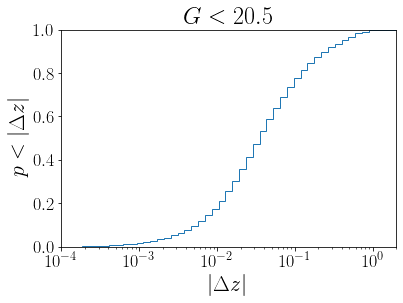

In [24]:
plt.title(rf'$G<{G_max_spz}$', fontsize=24)
plt.hist(abs(delta_z_G), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

Text(0, 0.5, 'number per bin')

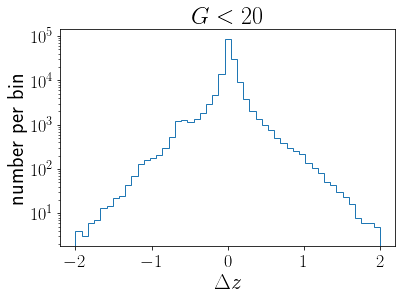

In [25]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(delta_z_G, bins=np.linspace(-2,2,50), histtype='step')
plt.yscale('log')
plt.xlabel(r'$\Delta z$')
plt.ylabel('number per bin')

(0.0, 1.0)

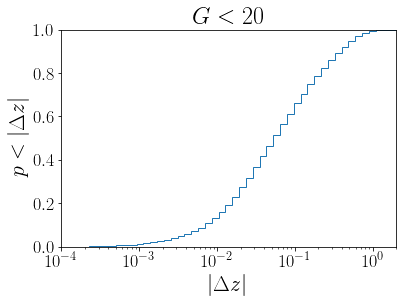

In [26]:
plt.title(rf'$G<{G_max}$', fontsize=24)
plt.hist(abs(delta_z), bins=np.logspace(-4, np.log10(2), 50), histtype='step', cumulative=True, density=True)
plt.xlabel(r'$|\Delta z|$')
plt.ylabel(r'$p < |\Delta z|$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)

# Look at 2mass data

In [213]:
fn_gaia_2mass = '/scratch/ksf293/gaia-quasars-lss/data/gaia_wise_panstarrs_tmass.fits.gz'

# Load data
print("Loading data")
tab_gaia_2mass = utils.load_table(fn_gaia_2mass)
print(tab_gaia_2mass.columns)

Loading data


<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','astrometric_excess_noise','visibility_periods_used','ipd_frac_multi_peak','ruwe','phot_g_n_obs','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_rp_excess_factor','in_qso_candidates','gaia_crf_source','vari_best_class_name','vari_best_class_score','fractional_variability_g','qso_variability','non_qso_variability','vari_agn_membership_score','classprob_dsc_combmod_quasar','classprob_dsc_combmod_galaxy','classlabel_dsc','classlabel_dsc_joint','classlabel_oa','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','n_transits','intensity_quasar','intensity_quasar_error','host_galaxy_detected','intensity_hostgalaxy','intensity_hostgalaxy_error','radius_hostgalaxy','radius_hostgalaxy_error','host_galaxy_flag','source_selection_flags','allwise_oid','designation','w1mpro','w2mpro','

In [214]:
tab_gaia_2mass.keep_columns(['source_id', 'j_m', 'h_m', 'ks_m'])

In [222]:
len(tab_gaia_2mass)
np.sum(np.isfinite(tab_gaia_2mass['j_m']))

175973

In [223]:
tab_gaia_2mass['j_m']

15.823
--
--
--
--
--
--
--
15.763
--
--


In [215]:
tab_gaia = astropy.table.join(tab_gaia, tab_gaia_2mass, keys='source_id', join_type='left')

In [225]:
i_has_2mass = np.isfinite(tab_gaia['ks_m'])
print(np.sum(i_has_2mass)/len(i_has_2mass))
print(np.sum(i_has_2mass), len(i_has_2mass))

0.06257976340251441
69140 1104830


Only 69k have tmass data :/

## Try GALEX!

In [228]:
fn_gaia_galex = '../data/gaia_galex.fits.gz'
print("Loading data")
tab_gaia_galex = utils.load_table(fn_gaia_galex)
print(tab_gaia_galex.columns)

Loading data
<TableColumns names=('ra','dec','source_id','raj2000','dej2000','fuvmag','nuvmag','objid')>


In [230]:
i_has_fuv = np.isfinite(tab_gaia_galex['fuvmag'])
print(np.sum(i_has_fuv)/len(i_has_fuv))
print(np.sum(i_has_fuv), len(i_has_fuv))

0.04299820037472391
285902 6649162


In [232]:
i_has_nuv = np.isfinite(tab_gaia_galex['nuvmag'])
print(np.sum(i_has_nuv)/len(i_has_nuv))
print(np.sum(i_has_nuv), len(i_has_nuv))

0.09610173432381404
638996 6649162


In [233]:
tab_gaia = astropy.table.join(tab_gaia, tab_gaia_galex, keys='source_id', join_type='left')

In [234]:
len(tab_gaia)

1104830

In [235]:
i_has_fuv = np.isfinite(tab_gaia['fuvmag'])
print(np.sum(i_has_fuv)/len(i_has_fuv))
print(np.sum(i_has_fuv), len(i_has_fuv))

0.17088330331363197
188797 1104830


In [236]:
i_has_fuv = np.isfinite(tab_gaia['nuvmag'])
print(np.sum(i_has_fuv)/len(i_has_fuv))
print(np.sum(i_has_fuv), len(i_has_fuv))

0.33084184897224006
365524 1104830


Dang, not enough :/